In [1]:
from modules import node, bandits, system
from modules import utils
from configs import config

import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Load data
with open('../data/channel_data_bs_5_140_ghz', 'rb') as fp:
    dataset_1 = pickle.load(fp)

# with open('../data/channel_data_round_2.pickle', 'rb') as fp:
#     dataset_2 = pickle.load(fp)

# with open('../data/channel_data_round_3.pickle', 'rb') as fp:
#     dataset_3 = pickle.load(fp)

# Create the channel and location data
H_1, loc_1 = utils.craft_data(dataset_1)
# H_2, loc_2 = utils.craft_data(dataset_2)
# H_3, loc_3 = utils.craft_data(dataset_3)

# concatenate the data
H = np.concatenate([H_1], axis=0)
loc = np.concatenate([loc_1], axis=0)

Before discarding zero data:  (8065, 4, 16) (8065, 2)
After discarding zero data:  (8064, 4, 16) (8064, 2)


In [3]:
# System configuration
# BS: 16 antennas and codebook size of 8
N_b = 16
M_b = 8

# UE: 4 antennas and codebook size of 4
N_u = 4
M_u = 4

# Location of BS
x_bs = dataset_1[0]['basestation']['location'][0][0]
y_bs = dataset_1[0]['basestation']['location'][0][1]

# Only the BS 5 is selected from the DeepMIMO dataset
BS = node.TRANSCEIVER(x=x_bs, y=y_bs, N=N_b, P=config.P_BS, M=M_b)
BS.construct_DFT_codebook(q=3)

UE = node.TRANSCEIVER(x=None, y=None, N=N_u, P=None, M=M_u)
UE.construct_DFT_codebook(q=3)

s = system.System(BS=BS, UE=UE, H=H, loc=loc)

In [4]:
all_arms = []
for i in range(s.BS.M):
    for j in range(s.UE.M):
        all_arms.append(
            bandits.ArmLinUCB(
                i=i, j=j
            )
        )

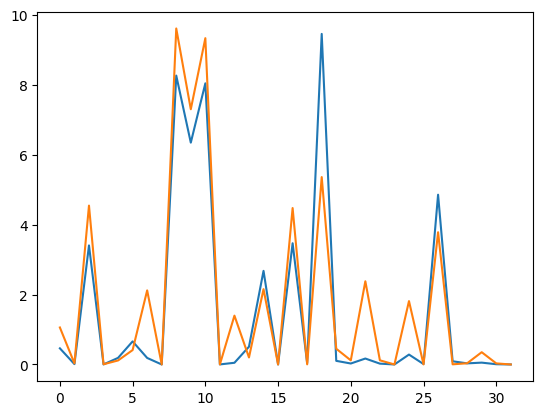

In [31]:
t = np.random.choice(8063)

probing_se = np.array([s.calc_SE_at_time_t(all_arms[i], t=t) for i in np.arange(0, 32, 1)])
completed_se = np.array([s.calc_SE_at_time_t(all_arms[i], t=t) for i in range(32)])

plt.plot(probing_se)
plt.plot(completed_se)

In [42]:
probing = []
#build data
for t in range(len(H)):
    probing_se = np.array([s.calc_SE_at_time_t(all_arms[i], t=t) for i in np.arange(0, 32, 8)])
    probing.append(probing_se.reshape(-1, 1))

In [45]:
with open('probing_data_bs_5_140_ghz', 'wb') as fp:
    pickle.dump(probing, fp)